This notebook loades in the model weights for each fine-tuned model and then evaluates the model on the custom InternData test set.

In [1]:
# ! pip install sklearn

In [2]:
import sys
import torch
sys.path.append('/irad_users/smithk/beholder-interns/')

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from intern_dataset import InternData
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision

transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                          torchvision.transforms.Normalize(
                                                              mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225]
                                                          )])

# get data and create dataloader 
data = InternData(img_dir = "/irad_mounts/lambda-quad-5-data/beholder/intern_data/jpg-data",
                  meta_path="/irad_mounts/lambda-quad-5-data/beholder/intern_data/annotations.csv",
                  split='test',
                  map_to_kitti=True,
                 transforms=transforms)
data_mlp = InternData(img_dir = "/irad_mounts/lambda-quad-5-data/beholder/intern_data/jpg-data",
                  meta_path="/irad_mounts/lambda-quad-5-data/beholder/intern_data/annotations.csv",
                  split='test',
                 transforms=transforms,
                      mlp=True)

dataloader = DataLoader(data,shuffle=False,batch_size=1,num_workers=1,collate_fn=data.collate_fn)
dataloader_mlp = DataLoader(data_mlp,shuffle=False,batch_size=1,num_workers=1,collate_fn=data.collate_fn)


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
import metrics
import itertools
import numpy as np

def get_metrics(dataloader, model, name):
    
    dist_pred, dist_actual = get_predictions(dataloader,model, name)

    dist_actual = list(itertools.chain.from_iterable(dist_actual))
    dist_pred = list(itertools.chain.from_iterable(dist_pred))

    # bring distance predictions and gts to flattened arrays
    distance_preds = np.concatenate([array.flatten() for array in dist_pred])
    distance_gts = np.concatenate([array.flatten() for array in dist_actual])

    # unnormalize distances
    distance_preds = (distance_preds+1)*(data.dist_max-data.dist_min)/2.0 + data.dist_min
    distance_gts = (distance_gts+1)*(data.dist_max-data.dist_min)/2.0 + data.dist_min

    # calculate metrics
    abs_rel_dist = np.mean(metrics.abs_relative_distance(distance_preds, distance_gts))
    sq_rel_dist = metrics.sq_relative_distance(distance_preds, distance_gts)
    rmse = metrics.rmse(distance_preds, distance_gts)
    log_rmse = metrics.log_rmse(distance_preds, distance_gts)

    out = {'Abs Rel': abs_rel_dist,
                    'Sq Rel': sq_rel_dist,
                    'RMSE': rmse,
                    'RMSE log': log_rmse}
    
    return out, distance_preds, distance_gts

In [6]:
# get predictions
def get_predictions(dataloader, model, name):
    class_actual = []
    class_pred = []
    dist_actual = []
    dist_pred = []
    img_index = []
    ind = 0
    total_boxes = []
    total_distances = []
    with torch.no_grad():
        for batch in dataloader:
            inputs,boxes,distances,classes = batch[0],batch[1],batch[2],batch[3]
            total_boxes.append(boxes)
            total_distances.append(distances)
            class_actual.append(batch[3])
            inputs = inputs.to(device)
            boxes = [b.to(device) for b in boxes]
            num_obj = [len(bbox_matrix) for bbox_matrix in boxes]
            # this will only work for batch size of 1
            img_index += [ind]*num_obj[0]
            ind += 1
            distances = torch.cat([d.to(device) for d in distances])
            if name == 'mlp':
                inputs = torch.cat([torch.cat([bbox.to(device), class_encoding.to(device)], dim=1) for bbox, class_encoding in zip(batch[1], batch[3])])
                distance_preds = model(inputs)
            else:
                 _,distance_preds,_ = model(inputs,boxes)
            distance_preds = distance_preds.cpu().numpy()
            distance_gts = distances.cpu().numpy()

            # reshape arrays to be batch x n_objects
            distance_preds = [distance_preds[i:i+num_obj[i]] for i in range(len(num_obj))]
            distance_gts = [distance_gts[i:i+num_obj[i]] for i in range(len(num_obj))]

            # append to list
            dist_pred.append(distance_preds)
            dist_actual.append(distance_gts)
    return dist_pred, dist_actual
        

In [7]:
from distnet import DistResNeXt50
# create model and load weights 
resnext = DistResNeXt50(8,image_size=1024, pretrained=False,keypoints=True)
resnext_pth = "/irad_users/determined/checkpoints/ec94f492-5600-4a68-8e4d-3cbc4d350424/state_dict.pth"
resnext.load_state_dict(torch.load(resnext_pth)['models_state_dict'][0],strict=True)
# put model in evaluate mode 
resnext.to(device)
resnext.eval()

DistResNeXt50(
  (backbone): ResNeXt50(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsamp

In [8]:
results = []
rsnext_metrics, rsnext_preds, rsnext_gt = get_metrics(dataloader, resnext, 'resnext')
print(rsnext_metrics)
results.append((rsnext_preds,rsnext_gt))

{'Abs Rel': 0.17281435, 'Sq Rel': 1.3997186, 'RMSE': 7.4551363, 'RMSE log': 0.24682999}


In [9]:
from distresnet import DistResNet18

resnet = DistResNet18(n_classes=8, image_size=1024, keypoints=True)
resnet.load_state_dict(torch.load('/irad_users/determined/checkpoints/90416ab0-c4ed-4448-b66a-a9c4defb73a7/state_dict.pth')['models_state_dict'][0], strict=True)
resnet.to(device)
resnet.eval()

DistResNet18(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [10]:
rsnet_metrics, rsnet_preds, rsnet_gt = get_metrics(dataloader, resnet, 'resnet')
print(rsnet_metrics)
results.append((rsnet_preds,rsnet_gt))

{'Abs Rel': 0.22847602, 'Sq Rel': 2.310869, 'RMSE': 11.120846, 'RMSE log': 0.2652936}


In [11]:
from mlpnet import DistanceRegressor

mlp = DistanceRegressor(n_features=10)
mlp.load_state_dict(torch.load('/irad_users/determined/checkpoints/6ac52028-4c4b-414d-a5d2-dfdc18959851/state_dict.pth')['models_state_dict'][0], strict=True)
mlp.to(device)
mlp.eval()

DistanceRegressor(
  (input): Linear(in_features=10, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=2048, bias=True)
  (output): Linear(in_features=2048, out_features=1, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (activation): Tanh()
)

In [12]:
mlp_metrics, mlp_preds, mlp_gt = get_metrics(dataloader_mlp, mlp, 'mlp')
print(mlp_metrics)
results.append((mlp_preds,mlp_gt))

{'Abs Rel': 0.47966102, 'Sq Rel': 7.996415, 'RMSE': 18.480791, 'RMSE log': 0.51150036}


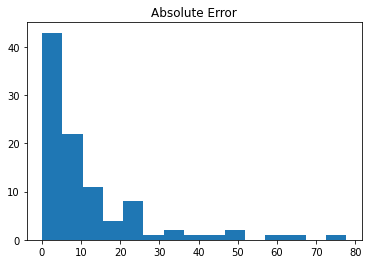

In [13]:
import matplotlib.pyplot as plt
# generate histogram of absolute error 
abs_error = [abs(d1 - d2) for d1, d2 in zip(mlp_preds,mlp_gt)]
plt.hist(abs_error, bins = 15)
plt.title("Absolute Error")

plt.show()

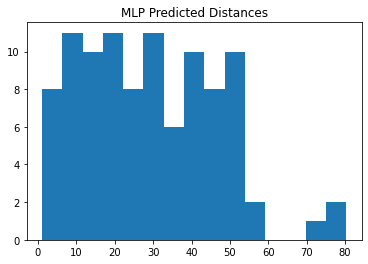

In [14]:
plt.hist(mlp_preds, bins = 15)
plt.title("MLP Predicted Distances")
plt.show()

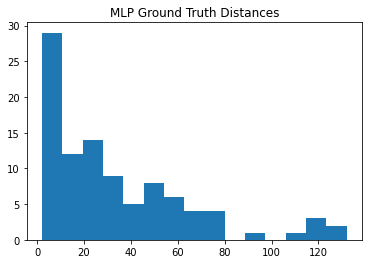

In [15]:
plt.hist(mlp_gt, bins = 15)
plt.title("MLP Ground Truth Distances")
plt.show()

In [16]:
for tup in results:
    print(tup[0][:5])

[14.615841  16.869678   8.658987   3.5071678  3.3612332]
[18.71549   17.875126  10.119362   5.6422744  4.8060584]
[21.764116  16.928434  32.5908     9.052911   2.4301922]


In [33]:
import torchvision.transforms as T
import matplotlib.patheffects as patheffects
from PIL import Image
import matplotlib

# Show a few accurate predictions
def get_error_img(error_min, error_max):
    color = (0,255,0)
    for i, err in enumerate(abs_error):
        if err > error_min and err < error_max:
            path = "/irad_mounts/lambda-quad-5-data/beholder/intern_data/jpg-data/" + data.metadata.index[i]
            for tup in results: 
                figure, ax = plt.subplots(1)
                im = matplotlib.image.imread(path) 
                # d = data.metadata.loc[data.sample_list[i]]
                d = data.metadata.loc[data.metadata.index[i]]
                # get the boxes, distances and classes
                boxes = np.array([d['x-min'].tolist(),
                                  d['y-min'].tolist(),
                                  d['x-max'].tolist(),
                                  d['y-max'].tolist()
                                 ])

                if type(boxes[0]) == np.float64:
                    boxes = np.array([boxes])
                else:
                    boxes = boxes.transpose()

                for j, box in enumerate(boxes):
                    distance_pred = tup[0][i+j]
                    distance_true = tup[1][i+j]
                    width = int(box[2])-int(box[0])
                    height = int(box[3])-int(box[1])
                    rect = matplotlib.patches.Rectangle((int(box[0]),int(box[1])),width,height, edgecolor='r', facecolor="none")
                    ax.add_patch(rect)
                    ax.text(box[0]-50,
                    box[1],
                    '$D_{{pred}}$ : {:.2f}m'.format(distance_pred),
                    verticalalignment='bottom',
                    color='white',
                    fontsize=10,
                    weight='bold').set_path_effects([patheffects.Stroke(linewidth=4,
                                                                        foreground='black'),
                                                     patheffects.Normal()])
                    ax.text(box[0]-50,
                    box[3],
                    '$D_{{true}}$ : {:.2f}m'.format(distance_true),
                    verticalalignment='top',
                    color='white',
                    fontsize=10,
                    weight='bold').set_path_effects([patheffects.Stroke(linewidth=4,
                                                                        foreground='black'),
                                                     patheffects.Normal()])
                ax.imshow(im)


/tmp/ipykernel_10503/1020891933.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure, ax = plt.subplots(1)


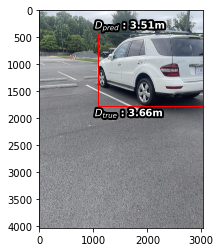

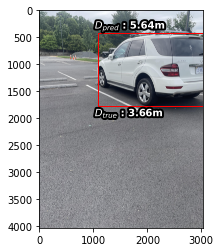

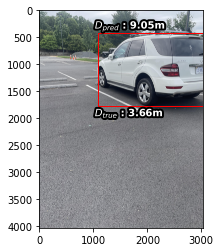

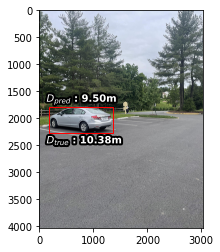

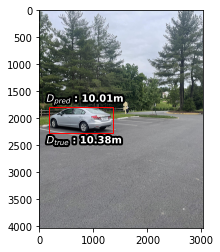

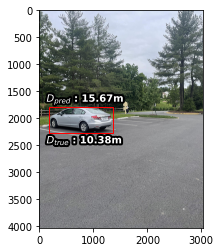

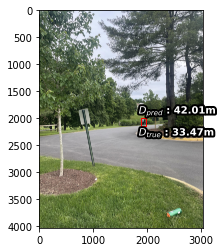

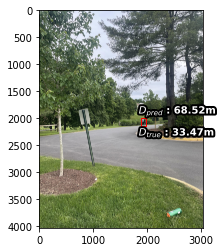

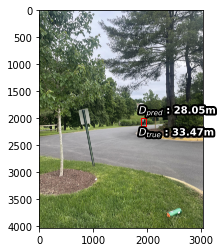

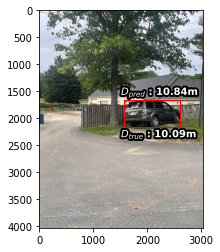

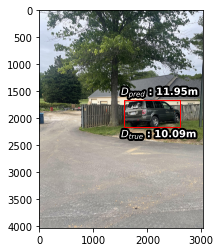

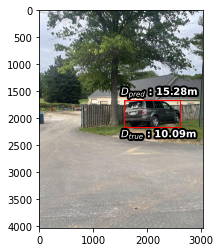

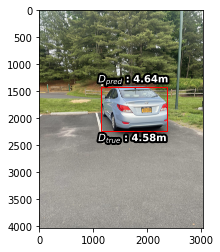

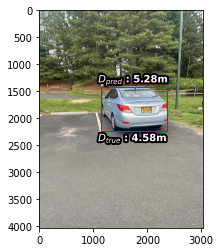

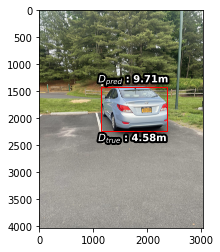

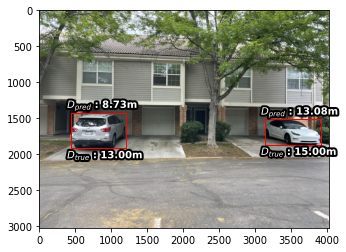

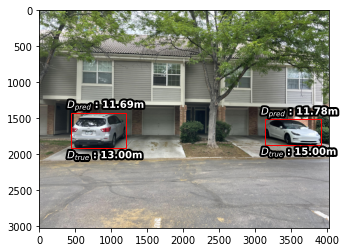

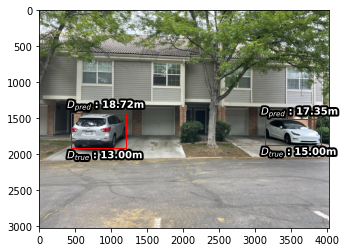

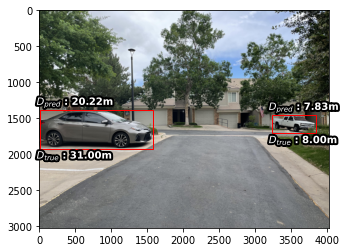

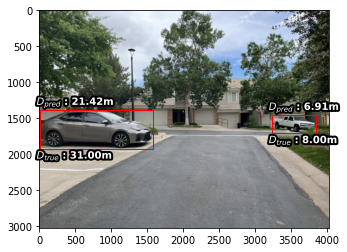

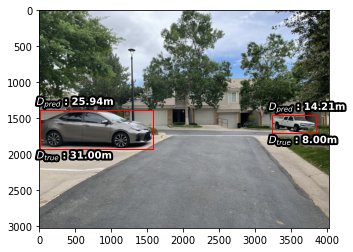

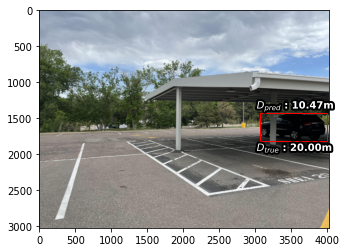

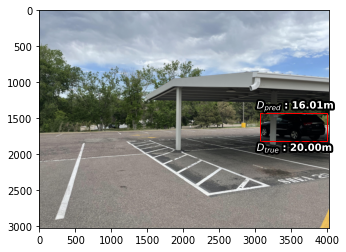

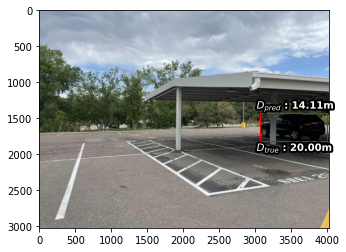

In [36]:
get_error_img(5,6)